**Note:** If you get any errors due to packages not being installed, please add them to the cell below. 

In [1]:
#!pip3 install gym

import gym
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

from IoTgraph import IoTgraph

## 1. Training

In [2]:
# Classification labels
NOT_MAL = 0
MAL = 1
DEAD_END = 2

# Controls some print statements for debugging
verbose = False

Create and render an instance of the `IoTgraph` class. 

Reminder on convention:
* `env.src` = Node 0
* `env.dst` = Highest numbered node

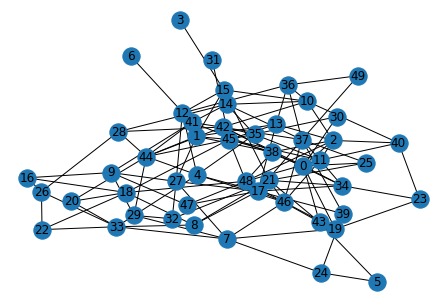

In [12]:
env = IoTgraph(network_size=50, edge_prob=0.1, percent_mal=0.3, attack_probs=[0.2, 0.8])
#env = IoTgraph('./env/env1.txt')

env.render()

Create lists of the intermediate nodes and their true labels.

In [13]:
int_nodes = list(range(1, env.dst))
labels_real = []

for a in env.devices:
    if a.node == env.src or a.node == env.dst:
        continue
    
    if a.mal:
        labels_real.append(MAL)
        
        if verbose:
            print(f'Node {a.node} IS malicious. Attack probability is {a.attack_prob:.2f}.')
    else:
        labels_real.append(NOT_MAL)
        
        if verbose:
            print(f'Node {a.node} is NOT malicious.')
            
print(int_nodes)
print(labels_real)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]


Some hyperparameters we introduce when we move to a RL environment:
* `corrupted_path_penalty` refers to the penalty our algorithm incurs when it takes a path that is corrupted. Setting this value is a choice; in this cell, we have made it equal to `env.network_size`, which means that a corrupted path is as bad or worse than the longest path in the network.
* `dead_end_penalty` refers to the penalty our algorithm incurs when it encounters a dead-end node. We don't need to consider this node for future pathfinding, so we put a high penalty on it. When we encounter a dead-end node, we don't ever want to visit it again. For this reason, we need to make the `dead_end_penalty` higher than any total penalty that could be incurred along a single path (since our Q-table keeps track of the **average** penalty for each node). The highest penalty would be a corrupted path that uses every single node in the network (`env.network_size + corrupted_path_penalty`). We multiply this by 2 just so the dead end nodes stand out more in the Q-table.
* `training_iterations` refers to the number of times we will try to find a path from the source to the destination. Too few iterations will lead to underfitting; too many will lead to overfitting.

The other hyperparameters are used for the Q-learning algorithm (definitions used from the [RL tutorial source](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)):
* `alpha` is the learning rate (0 < $\alpha$ <= 1). This captures the extent to which the Q-values are updated from one training iteration.
* `gamma` is the discount factor (0 < $\gamma$ <= 1). $\gamma$ determines how much importance we want to give to future rewards. A lower $\gamma$ makes our algorithm consider immediate rewards more, while a higher $\gamma$ captures a long-term effective reward.
* `epsilon` is the degree (0 < $\epsilon$ <= 1) to which we want to explore the action space (i.e. pick a random value) or exploit our learned Q-values. A lower $\epsilon$ will result in more penalties during training because we are more often picking new, unexplored paths. A higher $\epsilon$ will result in fewer penalties during training but may lead to overfitting.

In [14]:
training_iterations = 100000
rho_cp = 10 * env.network_size
rho_de = 2 * env.network_size

alpha = 0.1
gamma = 0.6
epsilon = 0.1

total_changes = 0

Initialize the Q table. Additionally, go through and find all of the nodes that don't connect to each other. Set these to -$\infty$, so we do not select these actions when training. Since our algorithm does not find cyclic paths (using the same node twice) and always ends when it reaches the destination, we will also set any pairs ending in the source or beginning with the destination to -infinity. The algorithm will never touch these values anyway, but it makes for a more clear Q-table.

In [15]:
q_table = np.zeros([env.num_states, env.num_actions])

for state in range(0, len(q_table)):
    possible_actions = list(range(0, len(q_table)))
    
    valid_neighbors = list(env.graph.neighbors(state))
    
    for action in possible_actions:
        action = int(action)
        if action not in valid_neighbors:
            q_table[state][action] = -np.Inf
       
q_table[:, env.src] = -np.Inf
q_table[env.dst, :] = -np.Inf
            
print(q_table)

[[-inf -inf   0. ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf   0. -inf]
 ...
 [-inf -inf -inf ... -inf   0. -inf]
 [-inf -inf   0. ...   0. -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]]


Train the algorithm. Some notes about this cell, because it is the most complicated cell in the notebook:
* We are trying to find paths from the source to the destination, and we go one node at a time. Think of the current state as the node we are currently at. The possible actions we can choose from are the other nodes that we can visit from this node (so, its neighbors). However, this is at odds with how we define the Q-table, where all actions are technically "valid" from each state. For this reason, we keep a `valid_neighbors` array to reference when we select an action. If a node is a dead end, it will have no valid neighbors and we can stop the training iteration. 
* When we are finding paths from the source to the destination, we don't want to visit the same node twice (this is called a cycle and can easily lead to infinite loops). We use the `VISITED` flag and `visit_arr` to mark whether we've visited a node in the current pathfinding iteration. This also helps us when we look at the `valid_neighbors` of a node. 

In [16]:
VISITED = -1
times_visited = np.zeros([env.num_states, env.num_actions])

# For plotting metrics
epoch_batch = []
penalty_batch = []

# Number of training iterations
for i in range(1, training_iterations+1):
    pct = (100 * i / training_iterations)
    if pct % 1 == 0:
        # print(f'{pct}%.')
        epoch_batch.append(pct)
        penalty_batch.append(total_changes)
        total_changes = 0
        
    # total_changes = 0 # total penalties AND rewards for this iteration
    total_penalty = 0
    path = []
    
    state = env.src
    prev_state = env.src # Use previous state to help keep track of dead ends
    
    done = False
    
    visit_arr = np.zeros(env.network_size)
    
    while not done:
        path.append(state)
        dead_end = True
        visit_arr[state] = VISITED # Shows that we have visited a node
        
        valid_neighbors = list(env.graph.neighbors(state)) # These are the valid possible actions
        
        # Check to see if the node is a dead end (if there are any valid neighbors, they have been visited already)
        for neighbor in valid_neighbors:
            if visit_arr[neighbor] != VISITED:
                dead_end = False
        
        # This node is a dead end, so we put a giant penalty on it so we don't go to it again in future iterations
        if dead_end:
            q_table[prev_state, state] = -rho_de
            total_changes += rho_de
            done = True

        # The node is not a dead end, so we continue trying to find paths to the destination
        else:  
            # Explore the action space by picking a random action
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
                
                # Make sure the action is valid by referencing the valid neighbors and visited arrays
                while action not in valid_neighbors or visit_arr[action] == VISITED:
                    action = env.action_space.sample()
            
            # Exploit learned values by selecting the best action from the current state based on our Q-table
            else:
                slc = q_table[state]
                action = np.argmax(slc)               

                # Make sure the action is valid by referencing the valid neighbors and visited arrays
                valid_action_exists = False
                
                # Another way to check for dead ends (and avoid infinite loops)
                for neighbor in valid_neighbors:
                    if visit_arr[action] != VISITED:
                        valid_action_exists = True
                
                if valid_action_exists:
                    while action not in valid_neighbors or visit_arr[action] == VISITED:
                        slc[action] = -np.Inf # Doing this helps prevent backtracking
                        action = np.argmax(slc)
                
                else:
                    q_table[prev_state, state] = -rho_de
                    total_changes += rho_de
                    done = True
                    
    
            # Now, we've finally selected an action. 
            # We can take the step and update the Q-table according to the algorithm.            
            next_state = action
            prev_state = state
            state = next_state

            if state == env.dst:
                path.append(state)
                done = True
                
            total_penalty += 1
    
    # Print out the path we took.
    # If we got to the destination, determine if that path was corrupted. Update the reward accordingly    
    if dead_end == True:
        if verbose:
            print(f'Path taken = {path}. Encountered a dead end.')
    else:               
        if env.is_corrupted(path):
            # The path is corrupted, but our algorithm doesn't know what node is the cause. 
            # So, we penalize all of the nodes. Over time, the nodes that are actually corrupted will be
            # penalized more often than the nodes that aren't.
            total_penalty += rho_cp
            total_changes += rho_cp
            #print(f'Path taken = {path}. This path was corrupted.')
            
        #print(f'Path taken = {path}.')
        
        # The path[0:len(path)-2] is a way of not penalizing the links that end in the destination node.
        # We want to update the Q table, but we want to keep it normalized relative to the dead end penalty.
        # So, we keep track of how many times we've encountered a (state, action) pair and keep track of the
        # average penalty incurred when going that way.
        for state in path[0:len(path)-2]:
            action = path[path.index(state)+1]
            visits = times_visited[state, action]
            if visits == 0:
                q_table[state, action] -= total_penalty
                
            else:
                avg_penalty = (q_table[state, action] * visits - total_penalty) / (visits + 1)
                q_table[state, action] = avg_penalty
                
            times_visited[state, action] += 1

## 3. Results and Analysis
Now that the training is finished, we can print out the Q table and try to visually confirm that our algorithm has learned the optimal paths. The rows represent the current state, and the columns represent the possible actions from that state. 

For each node, we would like to understand how 'trustworthy' it is when finding paths from the source to the destination. Each column reflects all of the paths that can involve an individual node. Even if a node is not malicious, it will be punished when it is involved in a corrupted or dead end path. Therefore, we compute the trustworthiness of each node by taking the maximum of each column of the Q table.

In [17]:
# For reference when reading the Q table
print(f'Corrupted path penalty is {rho_cp}.')
print(f'Dead end penalty is {rho_de}.')

q_table_df = pd.DataFrame(q_table)

print('\n')
print(q_table_df)

Corrupted path penalty is 500.
Dead end penalty is 100.


     0           1           2      3           4           5      6   \
0  -inf        -inf  -25.963398   -inf        -inf        -inf   -inf   
1  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
2  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
3  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
4  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
5  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
6  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
7  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
8  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
9  -inf        -inf        -inf   -inf        -inf        -inf   -inf   
10 -inf        -inf -151.062500   -inf        -inf        -inf   -inf   
11 -inf        -inf -211.142857   -inf        -inf        -inf   -

We would also like to identify which of the intermediate nodes are malicious. To do this, we classify based on criteria derived from the Q-table:
* The node is **not malicious** if its maximum column value is greater than `-dead_end_penalty`.
* If the node's maximum value is equal to `-dead_end_penalty`:
    1. **AND** all other finite values in the column are equal to `-dead_end_penalty`, it is a **dead end**. 
    2. **AND** there is a finite value in the column that is less than `dead_end_penalty`, it is **malicious**. 
    
From there, we can ignore all nodes that are classified as dead ends, since they won't factor into our accuracy calculations.

In [19]:
labels_pred = []

for name, data in q_table_df.iteritems():
    if name == env.src or name == env.dst:
        continue

    col_max = max(data.values)
    append_one = False
    
    if col_max > -rho_de:
        labels_pred.append(NOT_MAL)
    
    elif col_max == -rho_de:
        for val in data.values:
            if val > -np.inf and val < -rho_de:
                append_one = True
                break
        
        if append_one:
            labels_pred.append(MAL)
        else:
            labels_pred.append(DEAD_END)
        
    else:
        labels_pred.append(MAL)


# Remove the nodes labeled as dead ends since we don't factor them 
X = []
y_pred = []
y_hat = []

for x, y_p, y_h in zip(int_nodes, labels_pred, labels_real):
    if y_p != DEAD_END:
        X.append(x)
        y_pred.append(y_p)
        y_hat.append(y_h)
        
print(X)
print(y_pred)
print(y_hat)

[1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]


Now that we have classified each intermediate node and ignored the dead end nodes, we can compute the accuracy, precision, and recall of the classifications.

In [20]:
print(f'Accuracy: {accuracy_score(y_hat, y_pred):.2f}.')
print(f'Precision: {precision_score(y_hat, y_pred):.2f}.')
print(f'Recall: {recall_score(y_hat, y_pred):.2f}.')

print(confusion_matrix(y_hat, y_pred))

Accuracy: 0.80.
Precision: 0.62.
Recall: 0.93.
[[23  8]
 [ 1 13]]


We can also show how the algorithm converges over the course of a simulation runs. This measures the total change in the Q-table for each iteration and is recorded at each percentile of the run (i.e., when 1% of `training_iterations` have been run, 2%, and so on). The penalties are normalized since they are relative.

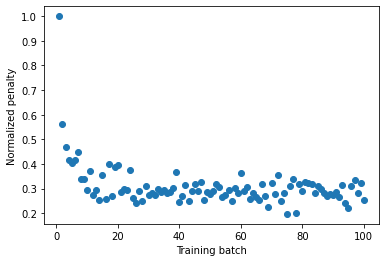

In [23]:
penalty_batch = [x / max(penalty_batch) for x in penalty_batch]
plt.scatter(epoch_batch, penalty_batch)
plt.xlabel('Training batch')
plt.ylabel('Normalized penalty')
plt.show()